# Xopt CNSGA algorithm

In [1]:
from xopt.generators.ga.cnsga import CNSGAGenerator

from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

from xopt import Xopt, Evaluator

In [2]:
# Useful for debugging
#%load_ext autoreload
#%autoreload 2

In [3]:
ev = Evaluator(function=evaluate_TNK)
ev.function_kwargs = {'raise_probability':0.1} # optional random crashing, to mimic real-world use. 

In [4]:
X = Xopt(
    generator=CNSGAGenerator(tnk_vocs),
    evaluator=ev,
    vocs=tnk_vocs,
)

In [5]:
%%time
# Run 100 generations
for _ in range(64 * 20):
    X.step()

CPU times: user 4.97 s, sys: 8.43 ms, total: 4.98 s
Wall time: 4.97 s


# Plot 

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Text(0.5, 1.0, "TNK with Xopt's CNSGA")

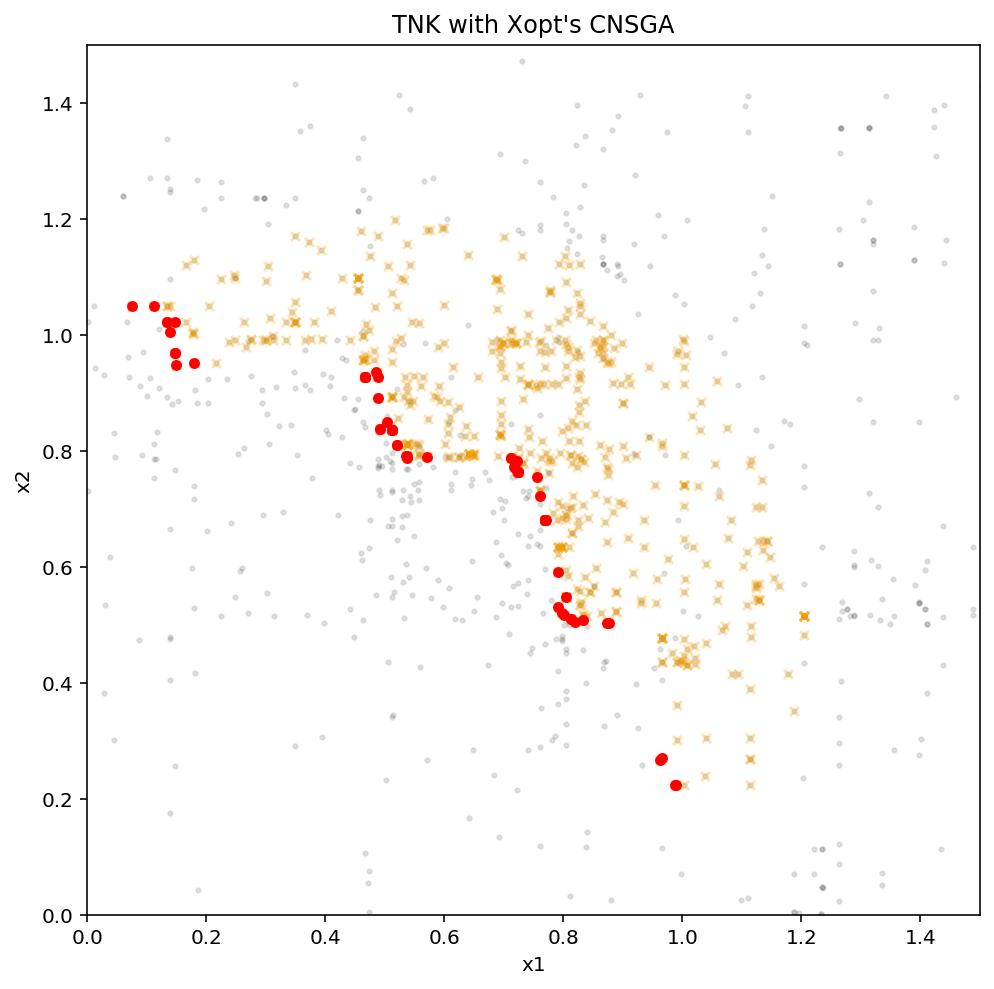

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

fdata = tnk_vocs.feasibility_data(X.data)

k1 = "x1"
k2 = "x2"

X.data.plot.scatter(k1, k2, marker=".", alpha=0.1, color="black", ax=ax)
X.data[fdata["feasible"]].plot.scatter(
    k1, k2, marker="x", alpha=0.3, color="orange", ax=ax
)
X.generator.population.plot.scatter(k1, k2, marker="o", color="red", alpha=1, ax=ax)
ax.set_xlabel(k1)
ax.set_ylabel(k2)
ax.set_xlim(0, 1.5)
ax.set_ylim(0, 1.5)
ax.set_title("TNK with Xopt's CNSGA")

In [8]:
# Write the current population
X.generator.write_population('test.csv')

# YAML method

In [9]:
from xopt import Xopt

In [10]:
YAML = """
xopt:
    max_evaluations: 6400
generator:
    name: cnsga
    population_size: 64
    population_file: test.csv
    output_path: .

evaluator:
    function: xopt.resources.test_functions.tnk.evaluate_TNK
    function_kwargs:
      raise_probability: 0.1

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    objectives: {y1: MINIMIZE, y2: MINIMIZE}
    constraints:
        c1: [GREATER_THAN, 0]
        c2: [LESS_THAN, 0.5]
    linked_variables: {x9: x1}
    constants: {a: dummy_constant}

"""

X = Xopt(YAML)
X


            Xopt
________________________________
Version: 0+untagged.1.g7582869
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: false, dump_file: null, max_evaluations: 6400}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: test.csv, output_path: .}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0, raise_probability: 0.1}
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constants: {a: dummy_constant}
  linked_variables: {x9: x1}


In [11]:
# This will have loaded children from the population file. These will need to be re-evaluated.
len(X.generator.children)

64

In [12]:
%%time
X.run()

CPU times: user 25.1 s, sys: 35.6 ms, total: 25.1 s
Wall time: 25.1 s


In [13]:
len(X.data)

6400

In [14]:
# With output_path set, these are written
from glob import glob
pop_files = sorted(glob("cnsga_population*"))
pop_files

['cnsga_population_2022-08-05T19:09:10.216372+00:00.csv',
 'cnsga_population_2022-08-05T19:09:10.456043+00:00.csv',
 'cnsga_population_2022-08-05T19:09:10.725952+00:00.csv',
 'cnsga_population_2022-08-05T19:09:10.967641+00:00.csv',
 'cnsga_population_2022-08-05T19:09:11.207578+00:00.csv',
 'cnsga_population_2022-08-05T19:09:11.448131+00:00.csv',
 'cnsga_population_2022-08-05T19:09:11.685209+00:00.csv',
 'cnsga_population_2022-08-05T19:09:11.923877+00:00.csv',
 'cnsga_population_2022-08-05T19:09:12.187500+00:00.csv',
 'cnsga_population_2022-08-05T19:09:12.453005+00:00.csv',
 'cnsga_population_2022-08-05T19:09:12.692490+00:00.csv',
 'cnsga_population_2022-08-05T19:09:12.931386+00:00.csv',
 'cnsga_population_2022-08-05T19:09:13.173023+00:00.csv',
 'cnsga_population_2022-08-05T19:09:13.414829+00:00.csv',
 'cnsga_population_2022-08-05T19:09:13.661252+00:00.csv',
 'cnsga_population_2022-08-05T19:09:13.929769+00:00.csv',
 'cnsga_population_2022-08-05T19:09:14.174624+00:00.csv',
 'cnsga_popula

<AxesSubplot:xlabel='x1', ylabel='x2'>

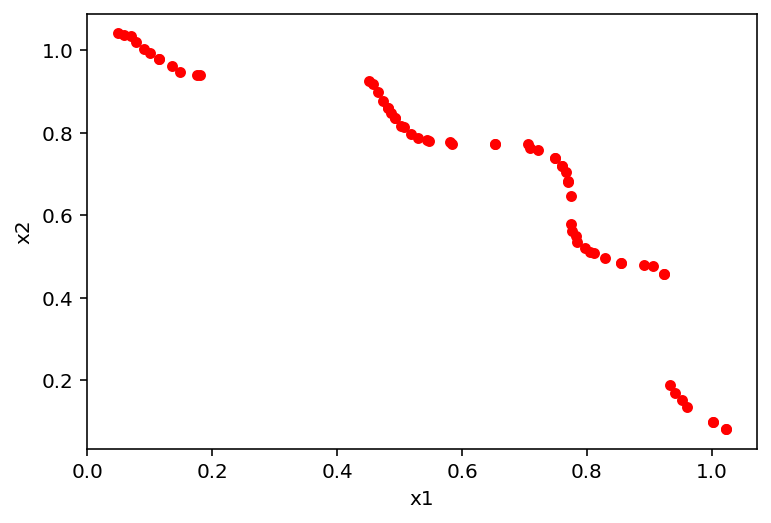

In [15]:
import pandas as pd
pop_df = pd.read_csv(pop_files[-1], index_col="xopt_index")

pop_df.plot.scatter("x1", "x2", marker="o", color="red", alpha=1)

In [16]:
# Cleanup
!rm cnsga_population*
!rm test.csv
